In [1]:
cwk_dir ="drive/MyDrive/NLU Coursework/" #For running in Jack's Google Drive

# Setup

## Connect Google Drive Folder

In [2]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


## Imports

In [104]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [3]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate, BatchNormalization, SimpleRNN, Attention, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D, TimeDistributed, subtract, multiply
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import keras
from keras.utils import to_categorical

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import typing
from PIL import Image
import json
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string
from random import randint
from itertools import chain
import spacy

In [5]:
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

In [6]:
#Imports from local libraries
sys.path.append(cwk_dir)
from classes.evaluation import evaluate, draw_confusion_matrix, most_confused_samples
from classes.preprocessing import load_data

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Primary Variables

Filepath variables

In [8]:
solution_dir = os.path.join(cwk_dir, "solution_B")
models_dir = os.path.join(solution_dir, "models_final")
results_dir = os.path.join(solution_dir, "results")

Preprocessing variables

In [9]:
LOWER: bool = True
PADDING: str = "post"

# nltk.download('stopwords')
# STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS = []

Training variables

In [10]:
# INITIAL_LR: float = 2e-5
INITIAL_LR: float = 0.001

EPOCHS: int = 20
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 256
DROPOUT: float = 0.3

LOSS_FUNCTION: str = "categorical_crossentropy"
OUTPUT_ACTIVATION: str = "softmax"
NUM_LABELS: int = 2

OPTIMIZER = RMSprop(INITIAL_LR)

Other

In [11]:
MAX_PREMISE_LENGTH: int = None
MAX_HYPOTHESIS_LENGTH: int = None

VOCAB_SIZE: int = None #None is the value to denote that there is no vocab size yet. This is set later, once we have the training data
EMBEDDING_SIZE: int = None

## Functions

In [12]:
NLP = spacy.load("en_core_web_sm")

def get_ner_tags(sentences: typing.List[str]) -> typing.List[str]:
  """
  Returns a list of the NER tags for a list of sentences
  """
  sentences = list(NLP.pipe(sentences))
  return [[token.ent_type_ for token in sentence] for sentence in sentences]

In [13]:
def pad_lists(lists, value, length: int):
  """
  Pads the lists with the value specified & returns this
  """
  return [(next + length * [value])[:length] for next in lists]

In [14]:
def average_sequence_length(sequence: typing.List[str]) -> int:
  """
  Takes a list of sentences & returns the average length of sentences in that sequence
  """
  lengths = [len(sample) for sample in sequence]
  return int(np.sum(lengths)/len(lengths)) + 1

In [15]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  model.summary()
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [16]:
def tokenize_data(tokenizer: BertTokenizer, premises: typing.List[str], hypotheses: typing.List[str]) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = [tokenizer.encode(premise, add_special_tokens=True) for premise in premises]
  hypotheses = [tokenizer.encode(hypothesis, add_special_tokens=True) for hypothesis in hypotheses]

  premises = pad_sequences(premises, maxlen=MAX_PREMISE_LENGTH, padding=PADDING, value=0)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_HYPOTHESIS_LENGTH, padding=PADDING, value=0)

  return (np.array(premises), np.array(hypotheses))

In [17]:
def save_keras_model(model: Model, filename: str) -> None:
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(models_dir, f"{filename}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(models_dir, f"{filename}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [18]:
def clean_sentences(sentences: typing.List[str]) -> typing.List[str]:
  """
  Takes a list of sentences & cleans them. Remove stopwords, reduces to lower case, removes punctuation
  """
  sentences = [[word.lower().translate(str.maketrans("","",string.punctuation)) for word in sentence.split(" ") if word not in STOP_WORDS] for sentence in sentences]
  sentences = np.array([" ".join(sentence) for sentence in sentences])
  return sentences


In [19]:
def plot_history(history, export_path, legend: typing.List[str] = ['train', 'test']):
  """
  Will plot the history of a model, labelling it appropriately
  """
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


# Data Preprocessing

## Load Data

In [22]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [23]:
dev_premises_og = dev_premises
dev_hypotheses_og = dev_hypotheses

In [24]:
MAX_PREMISE_LENGTH: int = average_sequence_length(sequence=train_premises)
MAX_HYPOTHESIS_LENGTH: int = average_sequence_length(sequence=train_hypotheses)

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [25]:
train_labels = to_categorical(train_labels)
dev_labels = to_categorical(dev_labels)

In [26]:
# #Removes stop words, punctuation
# train_premises = clean_sentences(sentences=train_premises)
# train_hypotheses = clean_sentences(sentences=train_hypotheses)

# dev_premises = clean_sentences(sentences=dev_premises)
# dev_hypotheses = clean_sentences(sentences=dev_hypotheses)

### Example

In [27]:
index = randint(0, len(train_premises))
print(f"Premise: {train_premises[index]}")
print(f"Hypothesis: {train_hypotheses[index]}")
print(f"Label: {train_labels[index]}")

Premise: Auditors should also send copies of the reports to other officials
Hypothesis: Auditors should keep their reports all to themselves.
Label: [1. 0.]


## Tokenize Data

In [28]:
# BERT_ID: str = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(BERT_ID)
# bert_model = BertModel.from_pretrained(BERT_ID)

BERT_ID: str = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(BERT_ID, do_lower_case=True)
bert_model = RobertaModel.from_pretrained(BERT_ID)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(train_premises), hypotheses=list(train_hypotheses))
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(dev_premises), hypotheses=list(dev_hypotheses))

In [30]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 50265


### Example

In [31]:
#Premise
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_premises[index])}")
print(f"Tokens: {train_premises[index]}")

Sentence: ['<s>', 'Aud', 'itors', 'Ġshould', 'Ġalso', 'Ġsend', 'Ġcopies', 'Ġof', 'Ġthe', 'Ġreports', 'Ġto', 'Ġother', 'Ġofficials', '</s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>']
Tokens: [    0 37779  9314   197    67  2142 11288     9     5   690     7    97
   503     2     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0    

In [32]:
#Hypothesis
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_hypotheses[index])}")
print(f"Tokens: {train_hypotheses[index]}")

Sentence: ['<s>', 'Aud', 'itors', 'Ġshould', 'Ġkeep', 'Ġtheir', 'Ġreports', 'Ġall', 'Ġto', 'Ġthemselves', '.', '</s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>']
Tokens: [    0 37779  9314   197   489    49   690    70     7  1235     4     2
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


## Embedding Matrix

In [33]:
embedding_matrix = bert_model.embeddings.word_embeddings.weight.detach().numpy()

In [34]:
if(EMBEDDING_SIZE is None):
  EMBEDDING_SIZE = np.shape(embedding_matrix)[1]
print(f"Embedding size: {EMBEDDING_SIZE}")

Embedding size: 768


# Experiment: BERT Embeddings

In [35]:
model_name = "bert_embed"

## Model Architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 110)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       multiple                     3860352   ['input_3[0][0]',             
                                                          0          'input_4[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 1024)                 5246976   ['embedding[0][0]',       

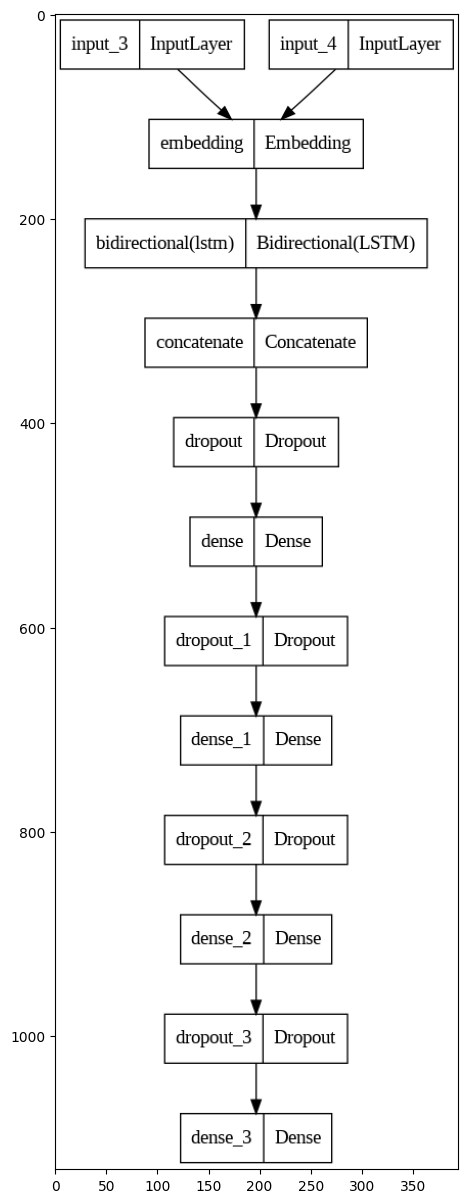

In [36]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

merged = concatenate([premises, hypotheses], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Model Training

In [37]:
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

In [38]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 34s 209ms/step - loss: 0.7046 - accuracy: 0.5508 - val_loss: 0.6338 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 16s 186ms/step - loss: 0.6310 - accuracy: 0.6453 - val_loss: 0.6000 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 16s 188ms/step - loss: 0.5973 - accuracy: 0.6758 - val_loss: 0.5972 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 16s 184ms/step - loss: 0.5781 - accuracy: 0.6919 - val_loss: 0.5745 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 15s 182ms/step - loss: 0.5601 - accuracy: 0.7050 - val_loss: 0.6063 - val_accuracy: 0.6526 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 16s 189ms/step - loss: 0.5387 - accuracy: 0.7213 - val_loss: 0.5873 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 7/20
85/85 [==============================] - 16s 189ms/st

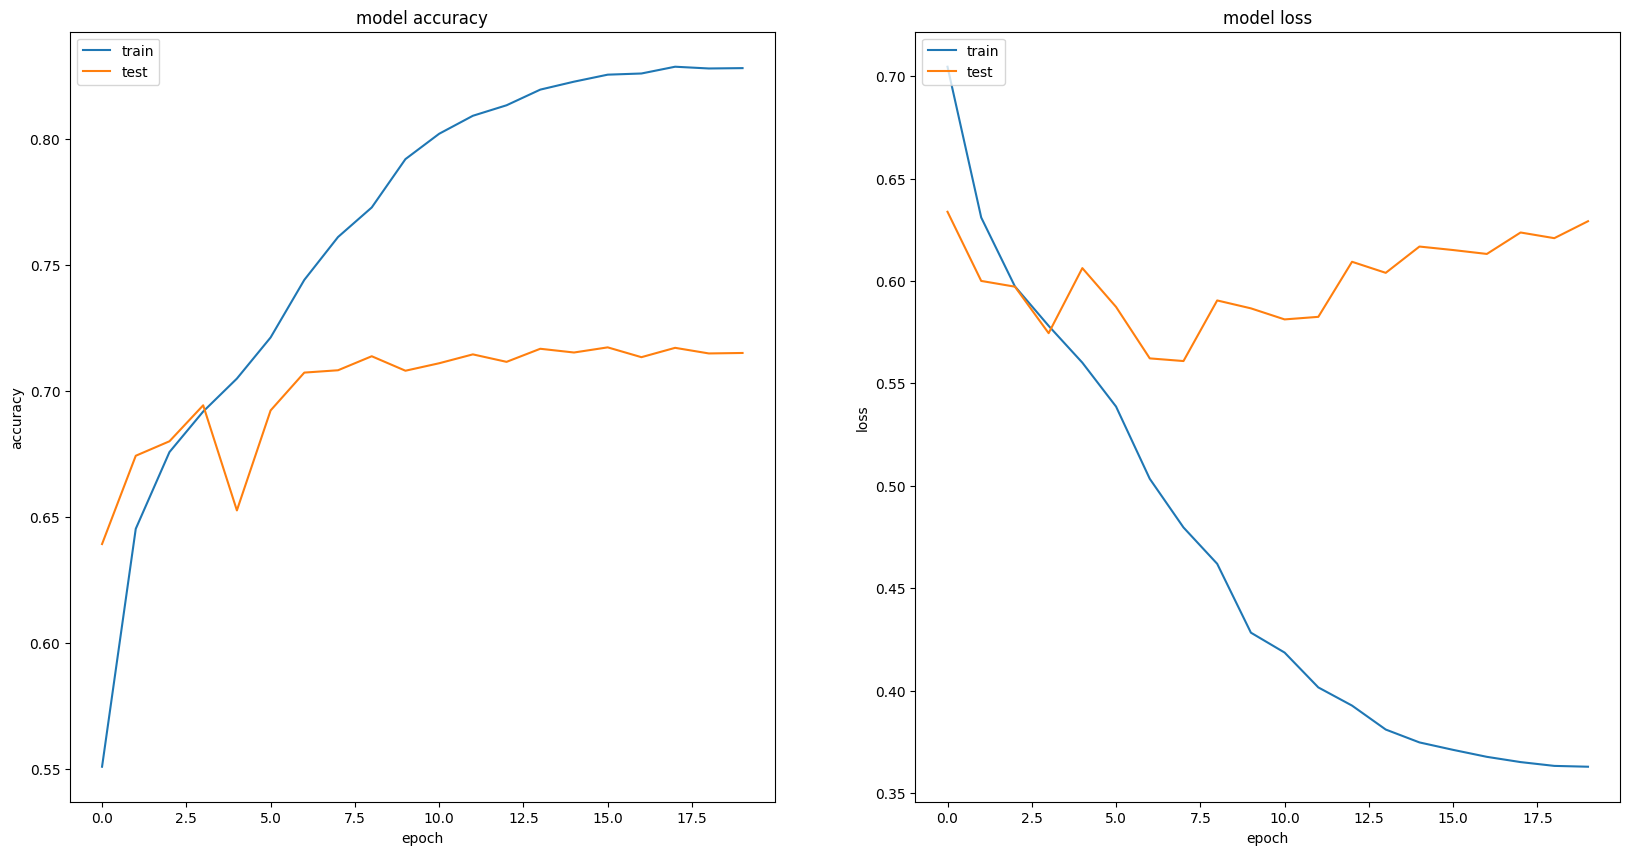

In [39]:
plot_history(history=history, export_path=f"{model_name}_architecture.pdf")

In [40]:
#Save the model
save_keras_model(model=model, filename="model_bert_embed")

## Model Evaluation

In [41]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 5s 15ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.716491,0.713159,0.716828,0.716709,0.754169,0.715225,0.716491,0.733091,0.71539,0.715966,0.43205,0.629002


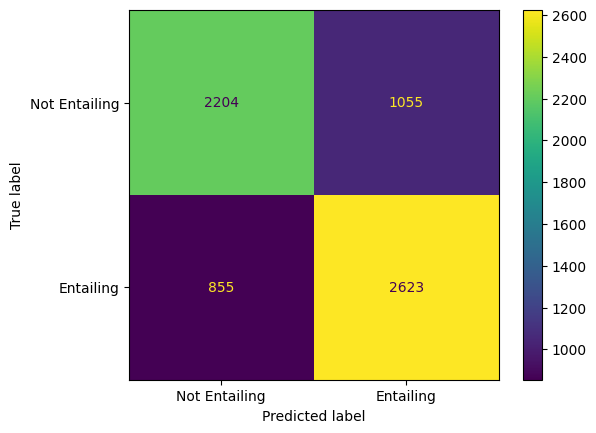

In [42]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [43]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,Computer Sciences Corporation (CSC) was an Ame...,Computer Sciences Corporation (CSC) was an Ame...,15.323475,1,0
1,He has collaborated on many occasions with Wyc...,He has collaborated on many occasions with Wyc...,14.048345,1,0
2,Artists with the finest of brushes paint the m...,Religious paintings called thangkas are not ma...,11.833160,1,0
3,yeah well they do well it it we found out that...,We found out only the really expensive stuff w...,11.261565,1,0
4,"Bryant for introducing the bill, Payne said.","Since the bill had already been introduced, Pa...",10.541729,1,0
5,The week moved quickly.,They did not waste any time that week.,10.430310,0,1
6,Good heavens! I said it quite quietly.,I couldn't speak up.,10.277985,0,1
7,"Conversely, the Congress might separate out so...",Congress might combine some of those functions.,10.110660,1,0
8,Ionian Greeks from the island of Samos settled...,"The Ionian Greeks briefly explored Ephesus, bu...",9.997131,1,0
9,"Well, Texas sure is a great big piece o' count...",Greenland is a nice time to visit in the summe...,9.556314,1,0


# Experiment: Multiplication Sentence Fusion


In [44]:
model_name = "model_multiplication_fusion"

## Model Architecture

In [45]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, min_delta=0.01)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 110)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     multiple                     3860352   ['input_5[0][0]',             
                                                          0          'input_6[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 1024)                 5246976   ['embedding_1[0][0]',   

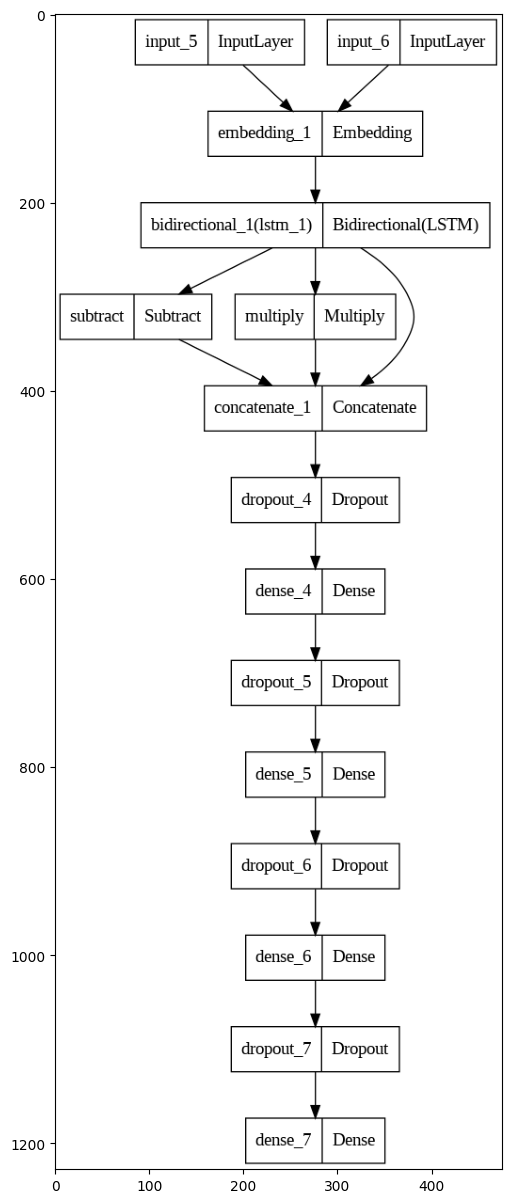

In [46]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

sub = subtract([premises, hypotheses])
mul = multiply([premises, hypotheses])
merged = concatenate([premises, hypotheses, sub, mul], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Training

In [47]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 23s 204ms/step - loss: 0.7149 - accuracy: 0.5738 - val_loss: 0.6309 - val_accuracy: 0.6363 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 16s 184ms/step - loss: 0.6150 - accuracy: 0.6585 - val_loss: 0.5974 - val_accuracy: 0.6710 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 15s 181ms/step - loss: 0.5893 - accuracy: 0.6805 - val_loss: 0.6535 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 15s 182ms/step - loss: 0.5671 - accuracy: 0.6954 - val_loss: 0.5906 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 15s 182ms/step - loss: 0.5266 - accuracy: 0.7258 - val_loss: 0.5493 - val_accuracy: 0.7209 - lr: 1.0000e-04
Epoch 6/20
85/85 [==============================] - 16s 184ms/step - loss: 0.5125 - accuracy: 0.7359 - val_loss: 0.5479 - val_accuracy: 0.7191 - lr: 1.0000e-04
Epoch 7/20
85/85 [==============================] - 16s 

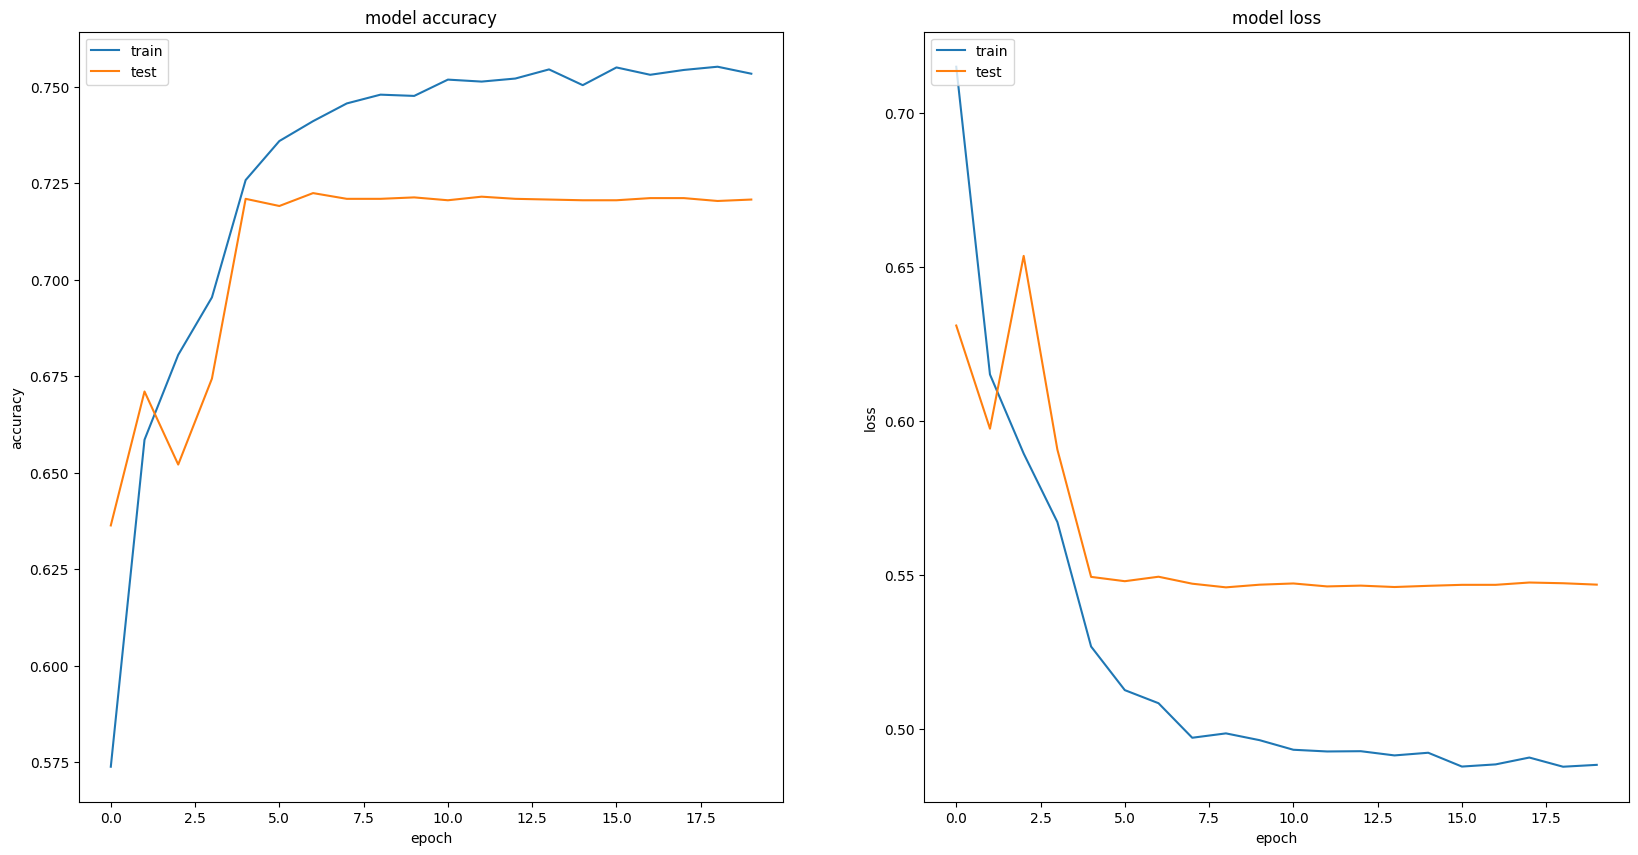

In [48]:
#Plot model
plot_history(history=history, export_path=f"{model_name}_history.pdf")

In [49]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Evaluate

In [50]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 4s 15ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.722725,0.713868,0.723904,0.723577,0.77257,0.72105,0.722725,0.74206,0.721158,0.721838,0.444945,0.544536


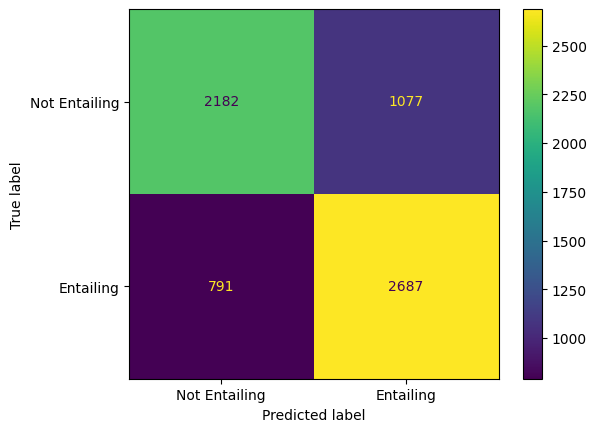

In [51]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [52]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,Ionian Greeks from the island of Samos settled...,"The Ionian Greeks briefly explored Ephesus, bu...",7.756036,1,0
1,"Today, Italy; tomorrow, who knows?",The trip to Italy will deplete my bank account...,7.299356,1,0
2,"We know this, because later she asked Dorcas t...",Dorcas did not bring any.,5.419472,0,1
3,okay well what are we doing about recycling in...,Our community does not recycle.,5.416172,0,1
4,The week moved quickly.,They did not waste any time that week.,5.304658,0,1
5,He shook his head and went looking for the ba...,There was no mirror anywhere in the bathroom.,5.098524,0,1
6,"Note that when haggling, the merchant assumes ...",Don't ever pay with a credit card with these m...,4.919236,0,1
7,"Oh, come now!",That is not possible!,4.888862,0,1
8,you want to have that coverage so anyway uh bu...,No press is bad press,4.852546,0,1
9,He was the first scholar to describe in detail.,He was the first scholar to describe in detail...,4.749238,1,0


# Experiment: Dennis Model
Inspired by: https://arxiv.org/abs/2203.06728

In [53]:
from transformers import XLNetTokenizer, XLNetModel

In [54]:
DROPOUT: float = 0.5
model_name = "dennis"

## Load Data

In [55]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [56]:
dev_premises_og = dev_premises
dev_hypotheses_og = dev_hypotheses

In [57]:
MAX_PREMISE_LENGTH: int = average_sequence_length(sequence=train_premises)
MAX_HYPOTHESIS_LENGTH: int = average_sequence_length(sequence=train_hypotheses)

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [58]:
train_labels = to_categorical(train_labels)
dev_labels = to_categorical(dev_labels)

In [59]:
# #Removes stop words, punctuation
# train_premises = clean_sentences(sentences=train_premises)
# train_hypotheses = clean_sentences(sentences=train_hypotheses)

# dev_premises = clean_sentences(sentences=dev_premises)
# dev_hypotheses = clean_sentences(sentences=dev_hypotheses)

### Example

In [60]:
index = randint(0, len(train_premises))
print(f"Premise: {train_premises[index]}")
print(f"Hypothesis: {train_hypotheses[index]}")
print(f"Label: {train_labels[index]}")

Premise: i admit that i used to be hooked on Dallas but back way long time ago when Jock died i gave up watching it it just got too funny
Hypothesis: I was never a fan of Dallas because it was just never funny enough for me. 
Label: [1. 0.]


## Tokenize Data

In [61]:
# BERT_ID: str = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(BERT_ID)
# bert_model = BertModel.from_pretrained(BERT_ID)

# BERT_ID: str = 'roberta-base'
# tokenizer = RobertaTokenizer.from_pretrained(BERT_ID, do_lower_case=True)
# bert_model = RobertaModel.from_pretrained(BERT_ID)

BERT_ID = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(BERT_ID, do_lower_case=False)
bert_model = XLNetModel.from_pretrained(BERT_ID)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [62]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(train_premises), hypotheses=list(train_hypotheses))
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(dev_premises), hypotheses=list(dev_hypotheses))

In [63]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 32000


### Example

In [64]:
#Premise
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_premises[index])}")
print(f"Tokens: {train_premises[index]}")

Sentence: ['▁', 'i', '▁admit', '▁that', '▁', 'i', '▁used', '▁to', '▁be', '▁hooked', '▁on', '▁Dallas', '▁but', '▁back', '▁way', '▁long', '▁time', '▁ago', '▁when', '▁J', 'ock', '▁died', '▁', 'i', '▁gave', '▁up', '▁watching', '▁it', '▁it', '▁just', '▁got', '▁too', '▁funny', '<sep>', '<cls>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Tokens: [   17   150  6024    29   

In [65]:
#Hypothesis
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_hypotheses[index])}")
print(f"Tokens: {train_hypotheses[index]}")

Sentence: ['▁I', '▁was', '▁never', '▁a', '▁fan', '▁of', '▁Dallas', '▁because', '▁it', '▁was', '▁just', '▁never', '▁funny', '▁enough', '▁for', '▁me', '.', '<sep>', '<cls>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Tokens: [  35   30  287   24 3054   20 4337  149   36   30  125  287 5787  456
   28  110    9    4    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


## Embedding Matrix

In [66]:
embedding_matrix = bert_model.get_input_embeddings().weight.detach().numpy()

In [67]:
if(EMBEDDING_SIZE is None):
  EMBEDDING_SIZE = np.shape(embedding_matrix)[1]
print(f"Embedding size: {EMBEDDING_SIZE}")

Embedding size: 768


## Model Architecture

In [75]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_5 (Embedding)     multiple                     2457600   ['input_13[0][0]',            
                                                          0          'input_14[0][0]']            
                                                                                                  
 bidirectional_5 (Bidirecti  multiple                     5246976   ['embedding_5[0][0]',   

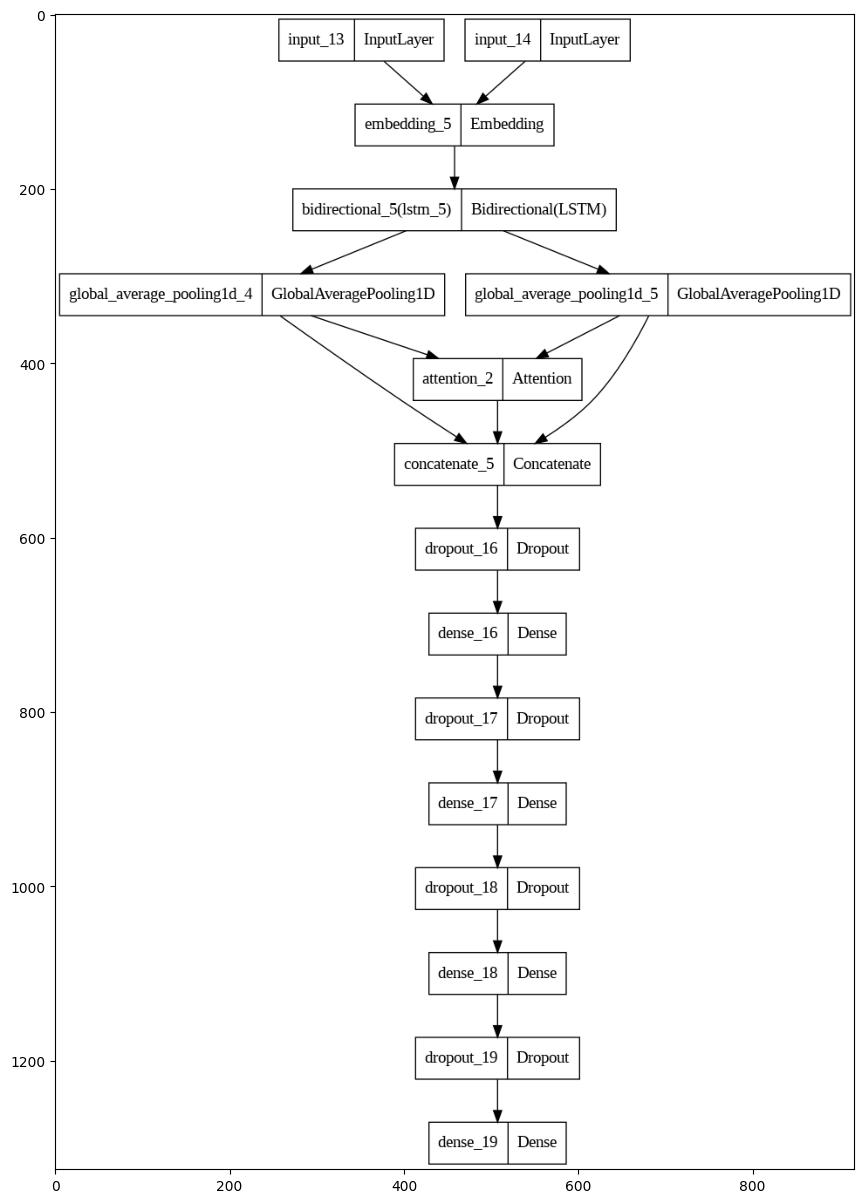

In [76]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=True, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

premises_pooling = GlobalAveragePooling1D()(premises)
hypotheses_pooling = GlobalAveragePooling1D()(hypotheses)

attention = Attention()([premises_pooling, hypotheses_pooling])
merged = concatenate([premises_pooling, hypotheses_pooling, attention], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Model Training

In [77]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 24s 205ms/step - loss: 0.7147 - accuracy: 0.5021 - val_loss: 0.6942 - val_accuracy: 0.4825 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 16s 188ms/step - loss: 0.6955 - accuracy: 0.5114 - val_loss: 1.2414 - val_accuracy: 0.5229 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 16s 192ms/step - loss: 0.6981 - accuracy: 0.5614 - val_loss: 0.6573 - val_accuracy: 0.6261 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 16s 193ms/step - loss: 0.6492 - accuracy: 0.6248 - val_loss: 0.6441 - val_accuracy: 0.6305 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 16s 188ms/step - loss: 0.6287 - accuracy: 0.6484 - val_loss: 0.6162 - val_accuracy: 0.6543 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 16s 188ms/step - loss: 0.6142 - accuracy: 0.6655 - val_loss: 0.5961 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 7/20
85/85 [==============================] - 16s 188ms/st

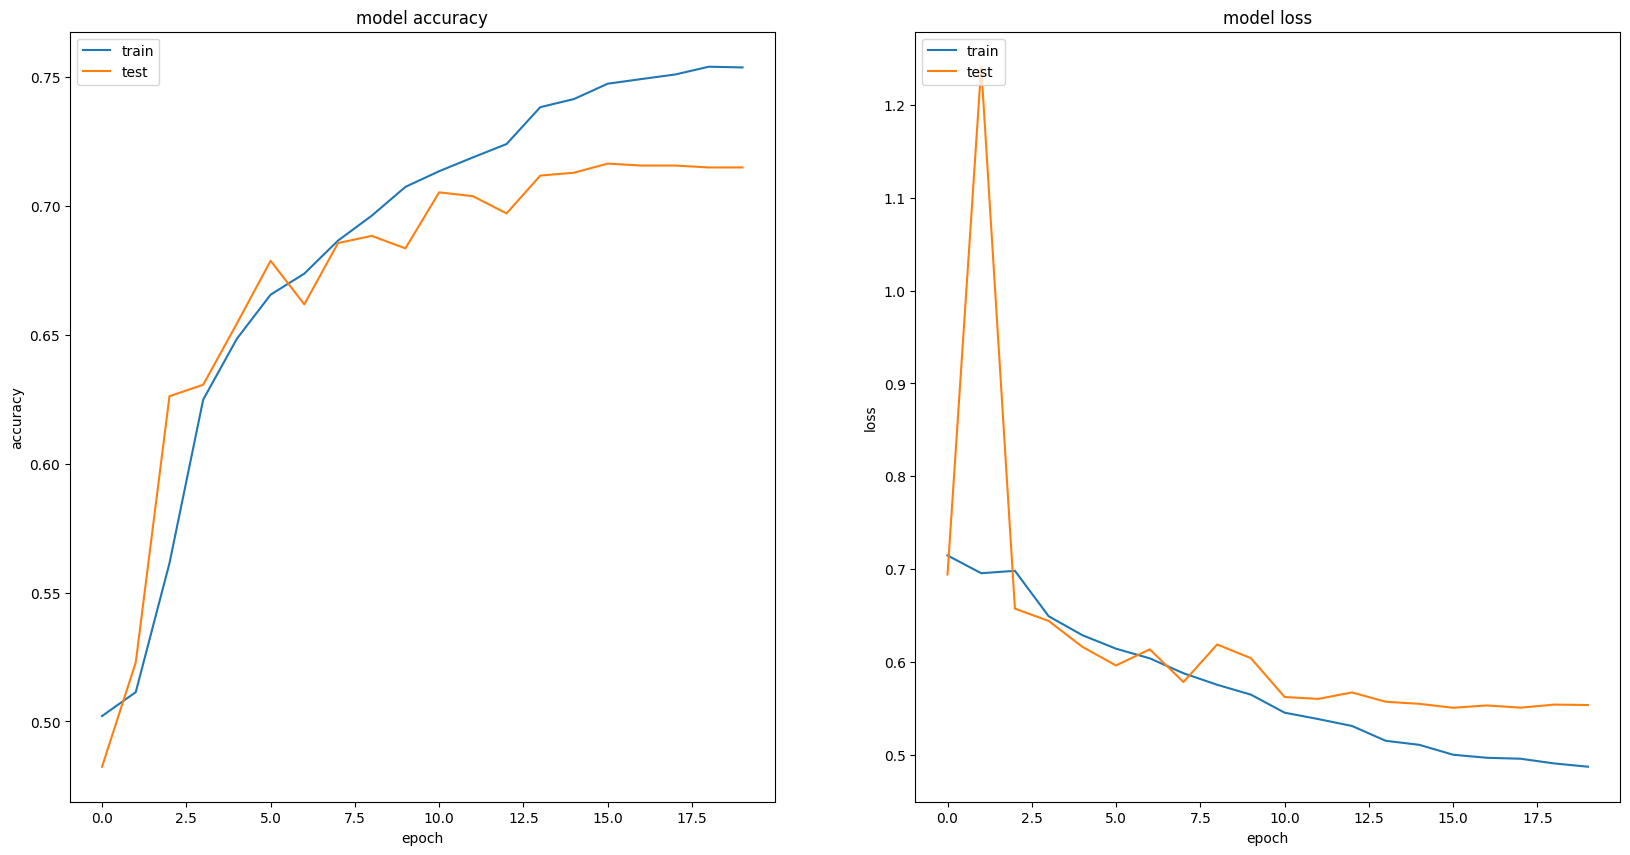

In [78]:
plot_history(history=history, export_path=f"{model_name}_architecture.pdf")

In [81]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Model Evaluation

In [82]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 8s 15ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.72035,0.711294,0.721583,0.721248,0.77142,0.718634,0.72035,0.740138,0.718719,0.719416,0.440207,0.539601


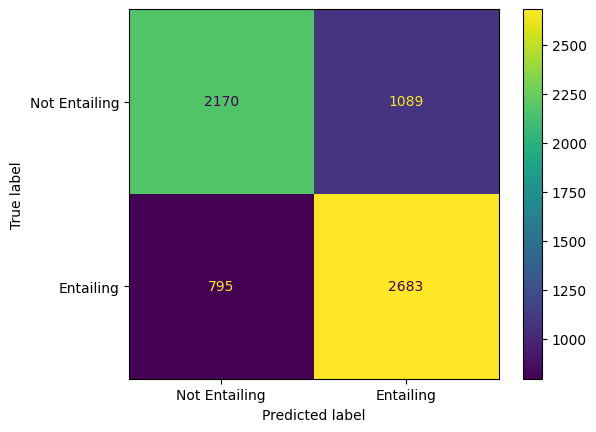

In [83]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [84]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,He was the first scholar to describe in detail.,He was the first scholar to describe in detail...,8.562391,1,0
1,"La Barredora (""The Sweeper Truck"") is a crimin...","La Barredora (""The Sweeper Truck"") is a crimin...",6.211633,1,0
2,Cain and Abel () is a 2009 South Korean televi...,Cain and Richard David Carrick () is a 2009 So...,5.801498,1,0
3,"Adelson's Internet career includes Netcom, DEC...","Adelson's Internet career includes Netcom, DEC...",5.630459,1,0
4,"We know this, because later she asked Dorcas t...",Dorcas did not bring any.,5.122826,0,1
5,Never was one to unspool th' bedroll till I wa...,I commit even though I don't know anything abo...,4.900271,1,0
6,Computer Sciences Corporation (CSC) was an Ame...,Computer Sciences Corporation (CSC) was an Ame...,4.880344,1,0
7,"The doctor kidded himself she took it herself,...","She's kidding herself, Julius said, the doctor...",4.840246,1,0
8,A key distinguishing factor in such individual...,A key distinguishing factor in such individual...,4.664730,1,0
9,yeah are you single okay uh,You've been engaged to someone for years?,4.637712,1,0


# Experiment: Combined Model

In [97]:
model_name = "combined"

## Model Architecture

In [89]:
OPTIMIZER = RMSprop(INITIAL_LR)
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_9 (Embedding)     multiple                     2457600   ['input_21[0][0]',            
                                                          0          'input_22[0][0]']            
                                                                                                  
 bidirectional_9 (Bidirecti  multiple                     5246976   ['embedding_9[0][0]',   

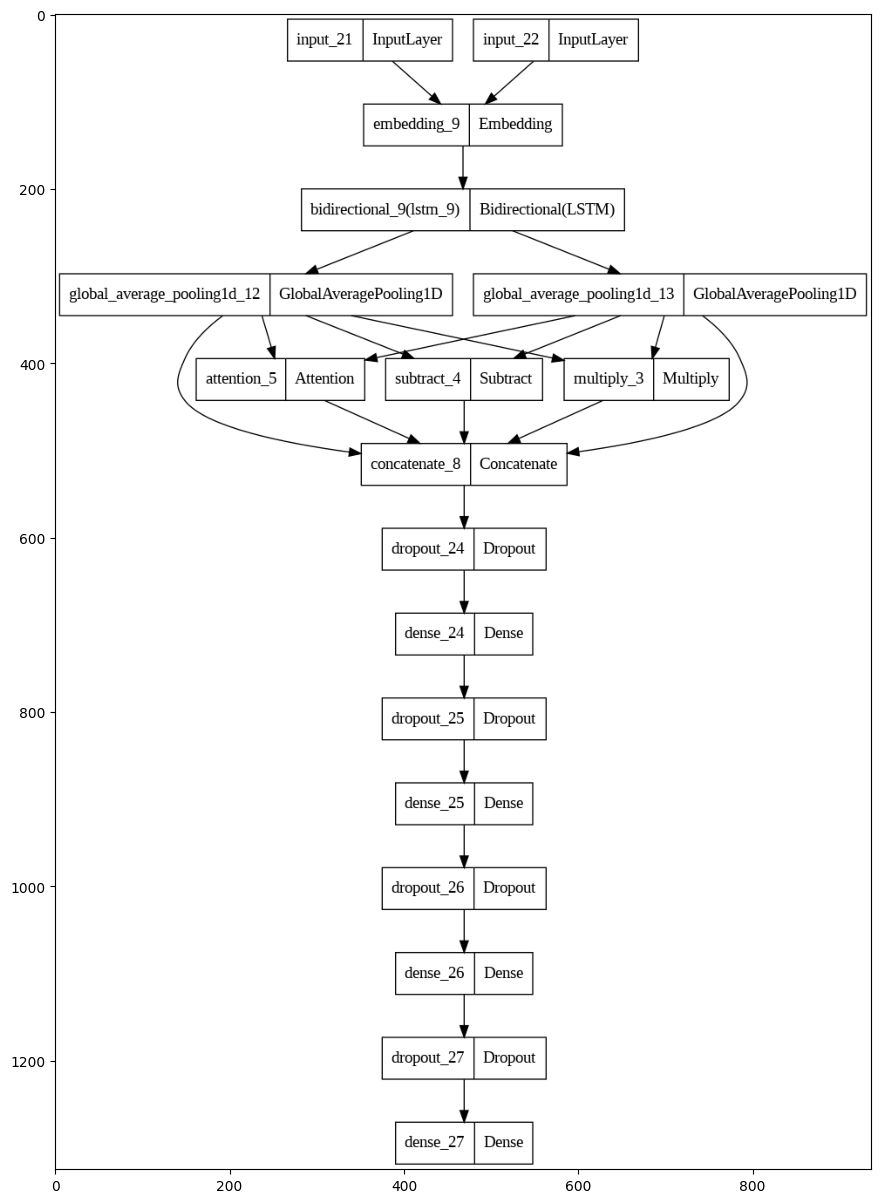

In [90]:
# input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
# input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

# embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
# premises = embedding_layer(input_premises)
# hypotheses = embedding_layer(input_hypotheses)

# lstm_layer = Bidirectional(LSTM(512, return_sequences=True, dropout=DROPOUT))
# premises = lstm_layer(premises)
# hypotheses = lstm_layer(hypotheses)

# premises_pooling = GlobalAveragePooling1D()(premises)
# hypotheses_pooling = GlobalAveragePooling1D()(hypotheses)

# attention = Attention()([premises_pooling, hypotheses_pooling])
# merged = concatenate([premises_pooling, hypotheses_pooling, attention], axis=-1)

# x = Dropout(DROPOUT)(merged)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(DROPOUT)(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(DROPOUT)(x)
# x = Dense(100, activation="relu")(x)
# x = Dropout(DROPOUT)(x)
# output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

# model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
# model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

# show_model_architecture(model=model, filename=f"{model_name}_architecture.png")


input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=True, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

premises_pooling = GlobalAveragePooling1D()(premises)
hypotheses_pooling = GlobalAveragePooling1D()(hypotheses)

sub = subtract([premises_pooling, hypotheses_pooling])
mul = multiply([premises_pooling, hypotheses_pooling])
attention = Attention()([premises_pooling, hypotheses_pooling])
merged = concatenate([premises_pooling, hypotheses_pooling, attention, sub, mul], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(2048, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Model Training

In [91]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 24s 212ms/step - loss: 0.7419 - accuracy: 0.5163 - val_loss: 0.6880 - val_accuracy: 0.5485 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 16s 189ms/step - loss: 0.6765 - accuracy: 0.5686 - val_loss: 0.6540 - val_accuracy: 0.6252 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 16s 190ms/step - loss: 0.6378 - accuracy: 0.6399 - val_loss: 0.6143 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 16s 190ms/step - loss: 0.6097 - accuracy: 0.6678 - val_loss: 0.5971 - val_accuracy: 0.6669 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 16s 190ms/step - loss: 0.5981 - accuracy: 0.6767 - val_loss: 0.6005 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 16s 189ms/step - loss: 0.5861 - accuracy: 0.6913 - val_loss: 0.5694 - val_accuracy: 0.6851 - lr: 0.0010
Epoch 7/20
85/85 [==============================] - 16s 190ms/st

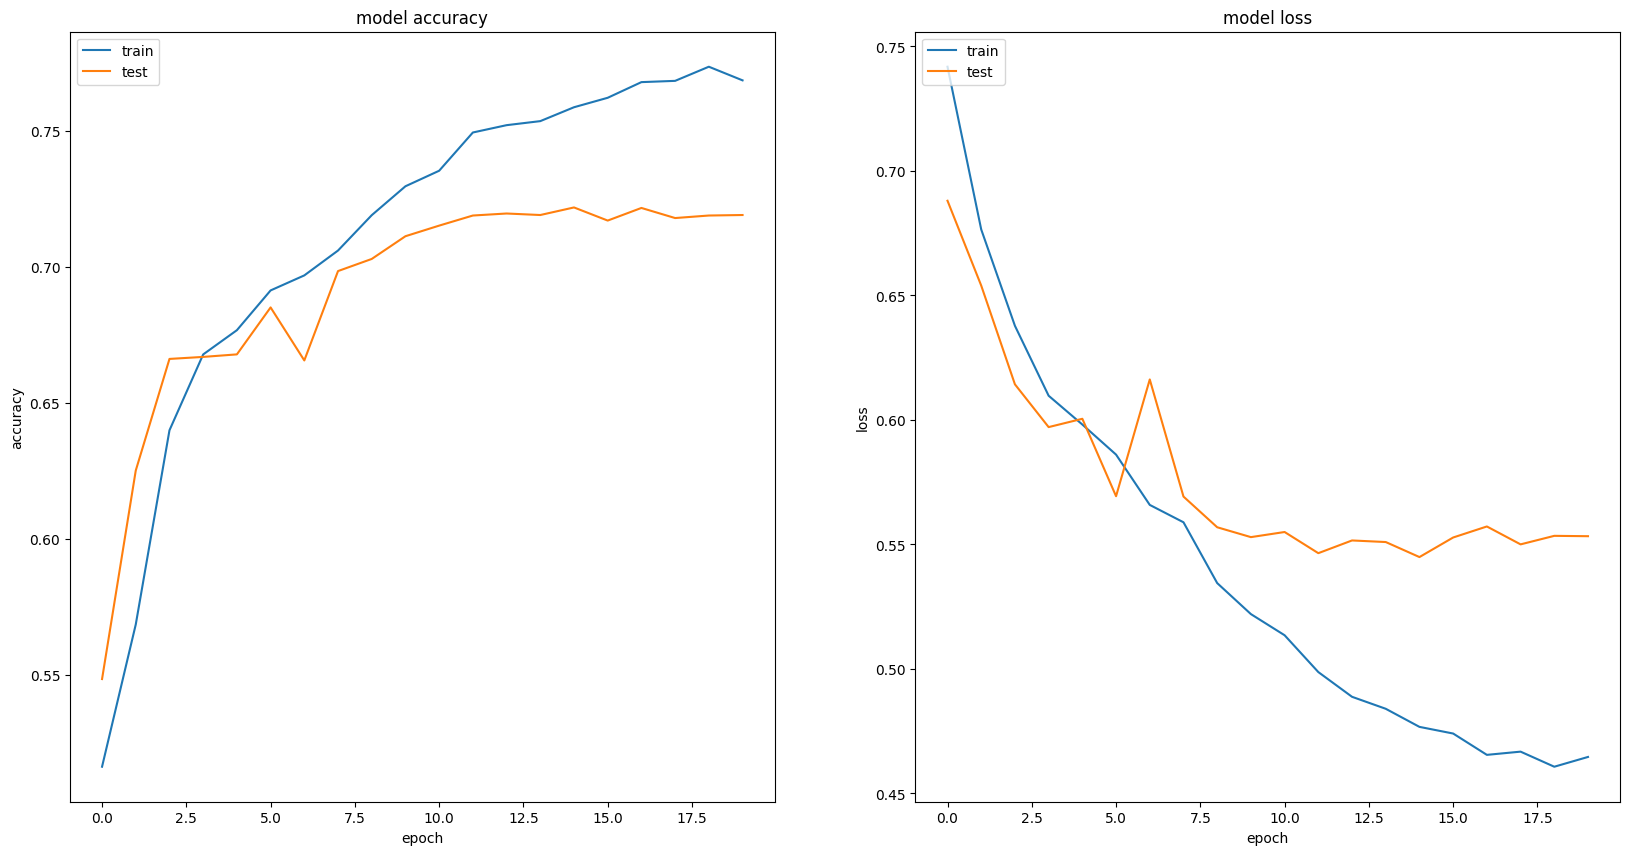

In [98]:
plot_history(history=history, export_path=f"{model_name}_architecture.pdf")

In [93]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Model Evaluation

In [99]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])
true_labels=np.argmax(dev_labels, axis=1)

#Evaluation Metrics
test_metrics = evaluate(true_labels=true_labels, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 3s 16ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.727772,0.728207,0.72774,0.727755,0.754169,0.726885,0.727772,0.74096,0.727065,0.727516,0.454624,0.535476


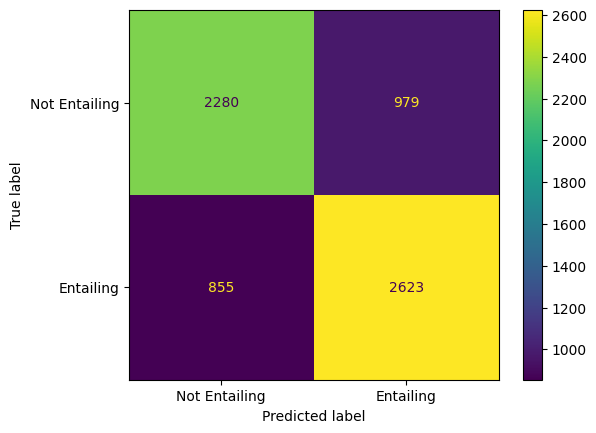

In [100]:
conf_mat = draw_confusion_matrix(true_labels=true_labels, predicted_logits=np.array(predicted_logits))

In [102]:
df = most_confused_samples(true_logits=dev_labels, predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df.to_csv(os.path.join(results_dir, f"{model_name}_most_confused.csv"), index=False)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,He was the first scholar to describe in detail.,He was the first scholar to describe in detail...,11.881137,1,0
1,"La Barredora (""The Sweeper Truck"") is a crimin...","La Barredora (""The Sweeper Truck"") is a crimin...",6.591391,1,0
2,"Today, Italy; tomorrow, who knows?",The trip to Italy will deplete my bank account...,5.636950,1,0
3,Traditional examples of background music inclu...,Traditional examples of background music inclu...,5.580024,1,0
4,Association for Federal Information Resources ...,The Government Executive magazine provides add...,5.529576,0,1
5,"Bryant for introducing the bill, Payne said.","Since the bill had already been introduced, Pa...",5.411198,1,0
6,no i'm sure you know that's one thing you don'...,I don't know whether you know if you should do...,5.375714,1,0
7,It's that interaction with fiscal policy that ...,It's that interaction with the criminal law is...,5.345931,1,0
8,"However, we are so sophisticated psychometrica...",No research can be dissected by methodology al...,5.317111,0,1
9,you want to have that coverage so anyway uh bu...,No press is bad press,5.285258,0,1
